Stuff about making sure u run stuff

In [234]:
# Load dependencies
import os

import matplotlib
import numpy as np
import cv2

import pyrender
from scipy.spatial.transform import Rotation

from IPython.display import display
from PIL import Image


In [235]:
# Define functions

def colorize(
    depth: np.ndarray,
    mask: np.ndarray = None,
    normalize: bool = True,
    cmap: str = "Spectral",
) -> np.ndarray:
    if mask is None:
        depth = np.where(depth > 0, depth, np.nan)
    else:
        depth = np.where((depth > 0) & mask, depth, np.nan)
    disp = 1 / depth
    if normalize:
        min_disp, max_disp = np.nanquantile(disp, 0.001), np.nanquantile(disp, 0.999)
        disp = (disp - min_disp) / (max_disp - min_disp)
    colored = np.nan_to_num(matplotlib.colormaps[cmap](1.0 - disp), 0)
    colored = (colored.clip(0, 1) * 255).astype(np.uint8)[:, :, :3]
    return colored

def fill_holes(image, depth, max_hole_size=30, window_size=5):
    if window_size % 2 == 0:
        window_size += 1
    
    valid_mask = depth > 0
    if np.all(valid_mask):
        return image
    
    filled_image = image.copy()
    working_mask = valid_mask.copy()
    
    mask_uint8 = valid_mask.astype(np.uint8) * 255
    
    # Create a distance transform map
    # The distance transform will help us find the holes
    dist_map = cv2.distanceTransform(255 - mask_uint8, cv2.DIST_L2, 5)
    holes_to_fill = (dist_map < max_hole_size) & (~valid_mask)
    
    if not np.any(holes_to_fill):
        return filled_image
    
    half_window = window_size // 2
    
    for dist in range(1, max_hole_size + 1):
        current_level = (dist_map >= dist-1) & (dist_map < dist) & holes_to_fill
        
        if not np.any(current_level):
            continue
        
        # For each hole pixel at this distance level
        for y, x in zip(*np.where(current_level)):
            # Define neighborhood
            y_min, y_max = max(0, y-half_window), min(image.shape[0], y+half_window+1)
            x_min, x_max = max(0, x-half_window), min(image.shape[1], x+half_window+1)
            
            neighborhood_mask = working_mask[y_min:y_max, x_min:x_max]
            
            if np.any(neighborhood_mask):
                neighborhood = filled_image[y_min:y_max, x_min:x_max]
                
                # Calculate average of valid pixels for each channel
                valid_pixels = neighborhood[neighborhood_mask]
                if len(valid_pixels) > 0:
                    # Average valid neighbors - ignores invalid pixels completely
                    avg_value = np.mean(valid_pixels, axis=0)
                    filled_image[y, x] = avg_value
                
                # Update working mask to mark this pixel as valid for next iteration
                working_mask[y, x] = True
    
    return filled_image

def pose_align(pose):
    matrix = np.identity(4)
    matrix[1, 1] = -1
    matrix[2, 2] = -1
    opengl_conversion_matrix = matrix
    align_rotation = np.eye(4)
    align_rotation[:3, :3] = Rotation.from_euler(
        "x", 180, degrees=True
    ).as_matrix()
    pose_aligned = (pose @ opengl_conversion_matrix)
    # pose_aligned = (pose @ opengl_conversion_matrix @ align_rotation)
    return pose_aligned

def render_to_image(pts3d, images, masks_conf=None, camera_pose=None, focal_length=None, height=None, width=None, point_size=3.0):
    H, W = images.shape[1:3]

    if height is None:
        height = H
    if width is None:
        width = W

    if height is not None and width == -1:
        width = int(height * W / H)
    if width is not None and height == -1:
        height = int(width * H / W)
    
    scene = pyrender.Scene(bg_color=(0, 0, 0))
    pc = pts3d.reshape(-1, 3)
    clr = images.reshape(-1, 3)
    if masks_conf is not None:
        mask = masks_conf.reshape(-1)
        pc = pc[mask.astype(bool)]
        clr = clr[mask.astype(bool)]

    cloud = pyrender.Mesh.from_points(pc, colors=clr)
    scene.add(cloud)
    
    if camera_pose is not None and focal_length is not None:
        camera_pose = pose_align(camera_pose)

        # Convert focal length to field of view
        fov = 2 * np.arctan(H / (2 * focal_length))
        camera = pyrender.PerspectiveCamera(yfov=fov, aspectRatio=width/height)
    else:
        camera = pyrender.PerspectiveCamera(yfov=np.pi/3.0, aspectRatio=width/height)
        camera_pose = np.eye(4)
        camera_pose[2, 3] = 2.0
    
    scene.add(camera, pose=camera_pose)
    
    r = pyrender.OffscreenRenderer(width, height, point_size)
    color, depth = r.render(scene, flags=pyrender.constants.RenderFlags.FLAT)
    
    return color, depth

def to_focal(focal, new_focal, pose, strength=1.0):
    forward = pose[:3, 2]

    forward = forward / np.linalg.norm(forward)

    diff = new_focal - focal

    ratio = diff / focal * strength

    new_pose = pose.copy()
    new_pose[:3, 3] -= forward * ratio

    return new_pose


def circleOfConfusion(focal_length, aperture_size, focal_distance, depth):
    # Circle of confusion formula
    return np.abs(
        aperture_size
        * ((depth - focal_distance) / focal_distance)
        * (focal_length / (focal_distance - focal_length))
    )


def apply_depth_of_field(
    image, depth_map, focal_length, focus_distance=None, aperture_size=10
):
    if focus_distance is None:
        focus_distance = np.mean(depth_map)

    focal_length /= 1000.0  # Convert to mm

    # Calculate circle of confusion for each pixel
    coc_map = circleOfConfusion(focal_length, aperture_size, focus_distance, depth_map)

    # Define discrete blur levels (kernel sizes)
    blur_levels = [1, 3, 7, 15, 31, 63]  # Kernel sizes must be odd

    # Create blurred versions of the image at different levels
    blurred_images = []
    for kernel_size in blur_levels:
        if kernel_size == 1:  # No blur
            blurred_images.append(image)
        else:
            blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
            blurred_images.append(blurred)

    # Convert CoC to kernel size
    kernel_sizes = 2 * coc_map + 1

    # Create the result image
    result = np.zeros_like(image, dtype=np.float32)

    # For each blur level pair
    for i in range(len(blur_levels) - 1):
        lower_size = blur_levels[i]
        upper_size = blur_levels[i + 1]

        # Find pixels with kernel sizes in this range
        mask = (kernel_sizes >= lower_size) & (kernel_sizes < upper_size)

        if np.any(mask):
            # Calculate interpolation weights
            alpha = (kernel_sizes - lower_size) / (upper_size - lower_size)
            alpha = np.clip(alpha, 0, 1)

            # Ensure mask and alpha have compatible dimensions with image
            if mask.ndim == 2 and image.ndim == 3:
                mask = mask[..., np.newaxis]
            if alpha.ndim == 2 and image.ndim == 3:
                alpha = alpha[..., np.newaxis]

            # Interpolate between the two blur levels
            interpolated = (1 - alpha) * blurred_images[i] + alpha * blurred_images[
                i + 1
            ]

            # Add to result
            result += mask * interpolated

    # Handle pixels with kernel size >= the maximum blur level
    mask = kernel_sizes >= blur_levels[-1]
    if mask.ndim == 2 and image.ndim == 3:
        mask = mask[..., np.newaxis]
    result += mask * blurred_images[-1]

    return result.astype(image.dtype), coc_map

In [236]:
# Load data

data_path = "out/lime".rstrip("/")

npz_file = np.load(os.path.join(data_path, f"{os.path.basename(data_path)}.npz"))

images = npz_file["images"]
pts3d = npz_file["pts3d"]
masks_conf = npz_file["masks_conf"]
focals = npz_file["focals"]
poses = npz_file["pred_poses"]

pose_index = 1

ori_focal_length = focals[0]
out_focal_length = focals[0]

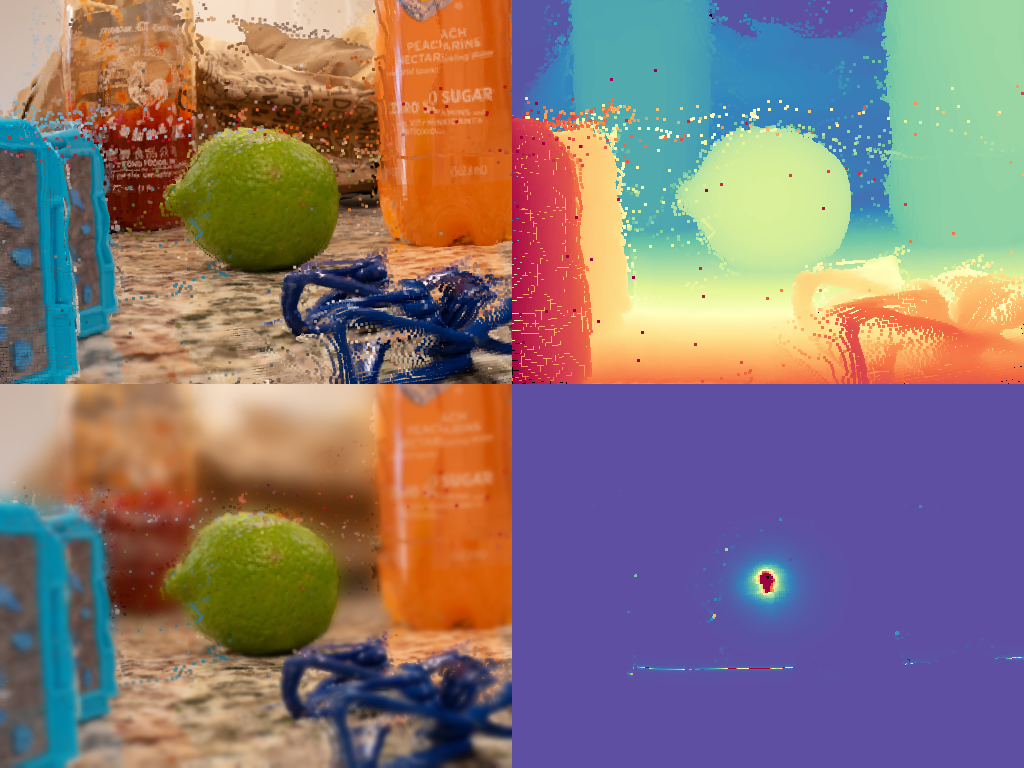

In [237]:
camera_pose = to_focal(ori_focal_length, out_focal_length, poses[pose_index], strength=1.3)

color, depth = render_to_image(
    pts3d, images, camera_pose=camera_pose, focal_length=out_focal_length, point_size=3.0
)

H, W = color.shape[:2]
focal_distance = depth[int(H * 0.5), int(W * 0.5)]

out, coc = apply_depth_of_field(
    color, depth, out_focal_length, focus_distance=focal_distance, aperture_size=2
)

display(
    Image.fromarray(
        np.vstack(
            (
                np.hstack((fill_holes(color, depth), colorize(depth))),
                np.hstack((out, colorize(coc))),
            )
        )
    )
)

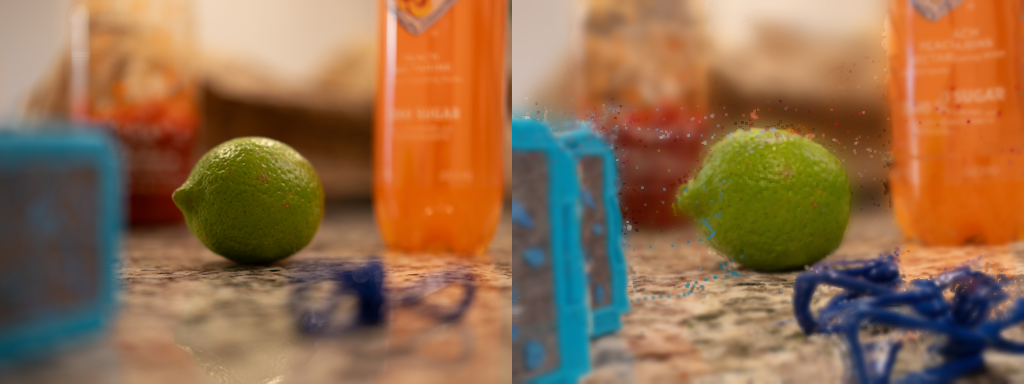

In [238]:
# Compare with ground truth.

# Load image from file
gt_image_path = "out/gt/gt/image_1.png"
gt_image = Image.open(gt_image_path)
gt_image = np.array(gt_image)

display(Image.fromarray(np.hstack((gt_image, out))))

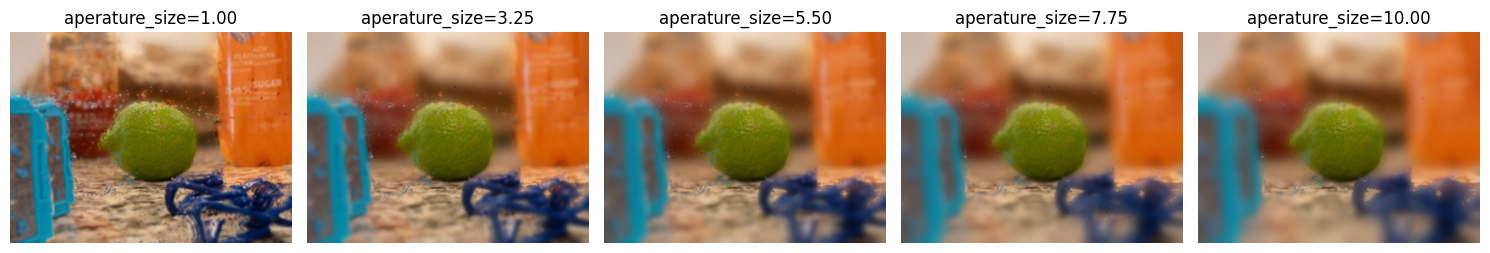

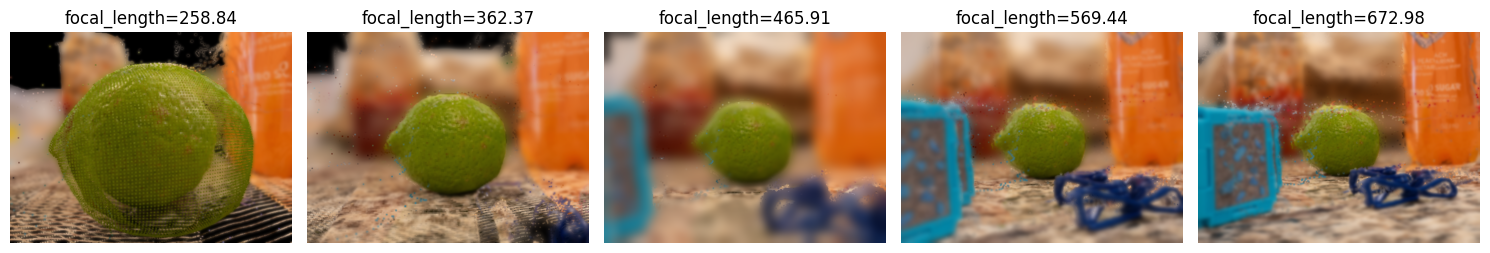

In [239]:
import matplotlib.pyplot as plt

aperatures = np.linspace(1, 10, 5)
result = []
for aperture in aperatures:
    out, coc = apply_depth_of_field(
        color, depth, out_focal_length, focus_distance=focal_distance, aperture_size=aperture
    )
    result.append(out)


fig, axs = plt.subplots(1, len(result), figsize=(15, 5))
for ax, img, aperture in zip(axs, result, aperatures):
    ax.imshow(img)
    ax.set_title(f"aperature_size={aperture:.2f}")
    ax.axis("off")
plt.tight_layout()
plt.show()

focal_lengths = [ori_focal_length * x for x in np.linspace(0.5, 1.3, 5)]
result = []
for focal_length in focal_lengths:
    camera_pose = to_focal(ori_focal_length, focal_length, poses[pose_index], strength=1.0)
    color, depth = render_to_image(
        pts3d,
        images,
        camera_pose=camera_pose,
        focal_length=focal_length,
        point_size=3.0,
    )
    focal_distance = depth[int(H * 0.5), int(W * 0.5)]
    out, coc = apply_depth_of_field(
        color, depth, focal_length, focus_distance=focal_distance, aperture_size=5 * (focal_length / ori_focal_length)
    )
    result.append(out)

fig, axs = plt.subplots(1, len(result), figsize=(15, 5))
for ax, img, focal_length in zip(axs, result, focal_lengths):
    ax.imshow(img)
    ax.set_title(f"focal_length={focal_length:.2f}")
    ax.axis("off")
plt.tight_layout()
plt.show()